<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/00_books/Machine_Learning_for_Asset_Managers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Asset Managers

## Ch1 - Introduction

## Ch2 - Denoising & Detoning

### Introduction

A **covariance matrix** is a squared matrix showing the covariance between each pair of variables (eg asset returns). The diagonal elements are the varainces of the single assets.

Cov matrix is essential for:
- Portfolio optimization -> allocation of weights to minimize risk or maximize returns
- Risk management -> measuring risk via variance and correlation
- ....

Which is the problem? Given a matrix

Empirical cov matrices are noisy, due to:
- Finite sample size of observations
- Imperfection of market data
- Many assets (N) and less observations (T)
This causes distortion of the true relationships

The **Marcenko-Pastur pdf** helps out!

Given a matrix X with N obesrvations and T assets with returns iid and variance σ^2, with cov matrix C = 1/T X'X then...

As N,T -> inf but q=N/T = cst then teh eigenvalues of C follow the MP pdf!

The MP distribution tells us that eigenalues λ are bounded in [λ-,λ+]

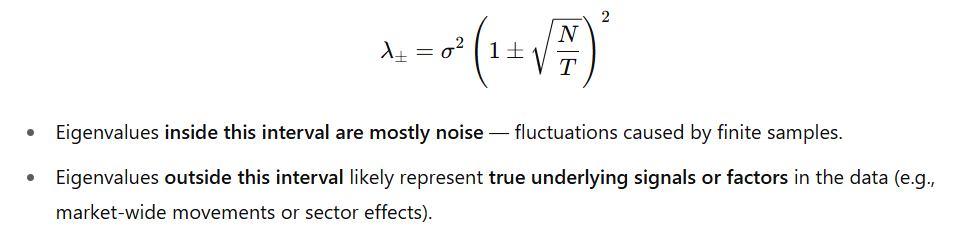

So we can:

1.  *Denoise*
- shrink (eliminate) noise eigenvalues to imporve the covariance estimate
- retain the infomrative eigenvalues
- Obtain a cleaner (denoised matrix)

2. *Detone*
- The largest λ corresponds (sometimes) to the market-wide systemic effect (common factor affecting all the assets).
- Detoning menas removing this dominant factor to analyze relationship beyond the general market movements!

In [1]:
import numpy as np, pandas as pd
#---------------------------------------------------
def mpPDF(var,q,pts):
#Marcenko-Pasturpdf
#q=T/N
  eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
  eVal=np.linspace(eMin,eMax,pts)
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
  pdf=pd.Series(pdf,index=eVal)
  return pdf

In [2]:
from sklearn.neighbors import KernelDensity
#---------------------------------------------------
def getPCA(matrix):
#Get eVal,eVec froma Hermitian (symmetric) matrix
  eVal,eVec=np.linalg.eigh(matrix)
  indices=eVal.argsort()[::-1]#arguments for sorting eVal desc
  eVal,eVec=eVal[indices],eVec[:,indices]
  eVal=np.diagﬂat(eVal)
  return eVal,eVec
#---------------------------------------------------
def ﬁtKDE(obs,bWidth=.25,kernel='gaussian',x=None):
#Fit kernel to a series of obs,and derive the prob of obs
#x is the array of values on which the ﬁt KDE will be evaluated
  if len(obs.shape)==1:obs=obs.reshape(-1,1)
  kde=KernelDensity(kernel=kernel,bandwidth=bWidth).ﬁt(obs)
  if x is None:x=np.unique(obs).reshape(-1,1)
  if len(x.shape)==1:x=x.reshape(-1,1)
  logProb=kde.score_samples(x)#log(density)
  pdf=pd.Series(np.exp(logProb),index=x.ﬂatten())
  return pdf
#---------------------------------------------------
x=np.random.normal(size=(10000,1000))
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0))
pdf0=mpPDF(1.,q=x.shape[0]/ﬂoat(x.shape[1]),pts=1000)
pdf1=ﬁtKDE(np.diag(eVal0),bWidth=.01)#empirical pdf

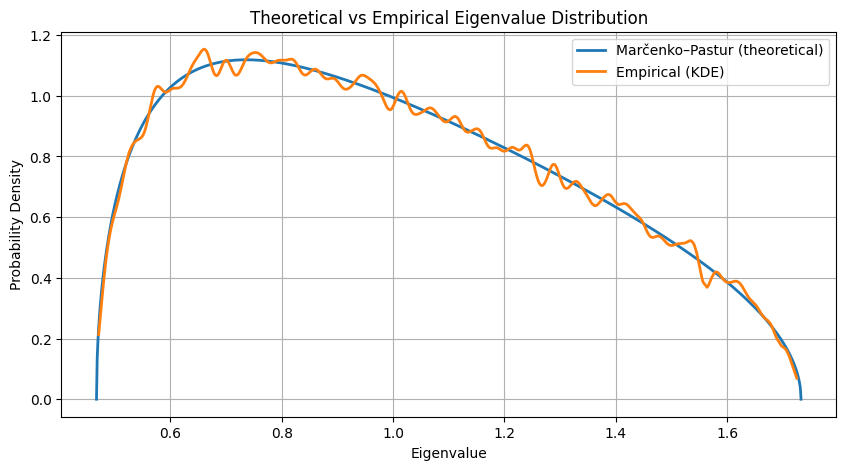

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
pdf0.plot(label='Marčenko–Pastur (theoretical)', lw=2)
pdf1.plot(label='Empirical (KDE)', lw=2)
plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Probability Density')
plt.title('Theoretical vs Empirical Eigenvalue Distribution')
plt.grid(True)
plt.show()


Now there is an issue.. with real data the cov matrix might be not perfectly random!

So we need to add a signal...

In [4]:
def getRndCov(nCols, nFacts):
    # Generate a random covariance matrix with specified number of factors
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # This is a low-rank (rank-deficient) matrix
    cov += np.diag(np.random.uniform(size=nCols))  # Add noise to make it full-rank
    return cov

def cov2corr(cov):
    # Convert a covariance matrix to a correlation matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1] = -1  # Clip due to numerical errors
    corr[corr > 1] = 1
    return corr

alpha = 0.995        # mixing weight: mostly empirical covariance, little signal
nCols = 1000         # number of variables (e.g., assets)
nFact = 100          # number of hidden factors (e.g., latent risk drivers)
q = 10               # T/N ratio = q => T = nCols * q

# Step 1: Create empirical covariance matrix from random data
raw_data = np.random.normal(size=(nCols * q, nCols))  # T=10,000 observations of 1,000 variables
cov_empirical = np.cov(raw_data, rowvar=False)

# Step 2: Create a structured signal covariance matrix
cov_signal = getRndCov(nCols, nFact)

# Step 3: Combine the two with alpha weighting
cov = alpha * cov_empirical + (1 - alpha) * cov_signal

# Step 4: Convert to correlation matrix
corr0 = cov2corr(cov)

# Step 5: Perform eigen decomposition
eVal0, eVec0 = getPCA(corr0)


In [5]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Computes sum of squared errors (SSE) between theoretical MP PDF and KDE fit of empirical eigenvalues
    pdf0 = mpPDF(var, q, pts)                           # Theoretical MP PDF
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)    # Empirical eigenvalue distribution
    sse = np.sum((pdf1 - pdf0)**2)                      # Sum of squared errors
    return sse
def findMaxEval(eVal, q, bWidth):
    # Optimize variance `var` that best fits the empirical eigenvalue distribution to MP
    out = minimize(lambda x: errPDFs(x[0], eVal, q, bWidth), x0=[0.5], bounds=[(1E-5, 1 - 1E-5)])

    if out['success']:
        var = out['x'][0]
    else:
        var = 1  # fallback

    # Compute the theoretical maximum eigenvalue (λ+)
    eMax = var * (1 + (1. / q)**0.5)**2
    return eMax, var

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)

# Count number of signal eigenvalues above the noise threshold
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)


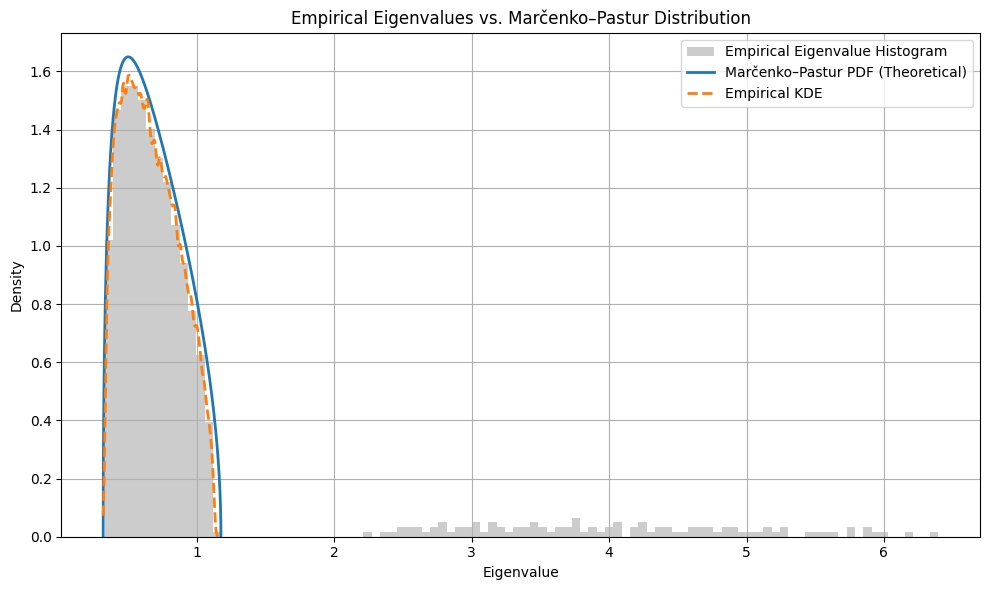

In [6]:
import matplotlib.pyplot as plt

# Flatten eigenvalues (they're in a diagonal matrix)
empirical_eVals = np.diag(eVal0)

# Fit theoretical Marčenko–Pastur PDF
pdf_mp = mpPDF(var0, q, pts=1000)

# Fit KDE to empirical eigenvalues
pdf_empirical = fitKDE(empirical_eVals, bWidth=0.01, x=pdf_mp.index.values)

# Plotting
plt.figure(figsize=(10,6))
plt.hist(empirical_eVals, bins=100, density=True, alpha=0.4, color='gray', label='Empirical Eigenvalue Histogram')
plt.plot(pdf_mp.index, pdf_mp.values, label='Marčenko–Pastur PDF (Theoretical)', linewidth=2)
plt.plot(pdf_empirical.index, pdf_empirical.values, label='Empirical KDE', linewidth=2, linestyle='--')

plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Empirical Eigenvalues vs. Marčenko–Pastur Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
nFacts0, var0

(np.int64(100), np.float64(0.6777927416541262))

-  Eigenvalues to the right of the ﬁtted
Marcenko–Pastur distribution cannot be associated with noise, thus they are
related to signal.
- The ﬁtted distribution implies that σ2 ≈ :6768, indicating that only about 32.32% of the variance can be attributed to signal. This is one way of measuring
the signal-to-noise ratio in ﬁnancial data sets, which is known to be low as a result of arbitrage forces.

### Denoising

In general applications it is important to shirnk a covaraince matrix when tis is bad conditioned.

- The condition number k(A) = λ_max/λ_min
- when k(A) is too big the matrix is ill-conditioned (that is small input errors are propagated at the output)
- This creates plrobelm for example if need to invert the matrix... it might be singular due to numerial error!


So we want to make it closed to a diagonal matrix -> a diagonal cov matrix has zero cov between different assets)

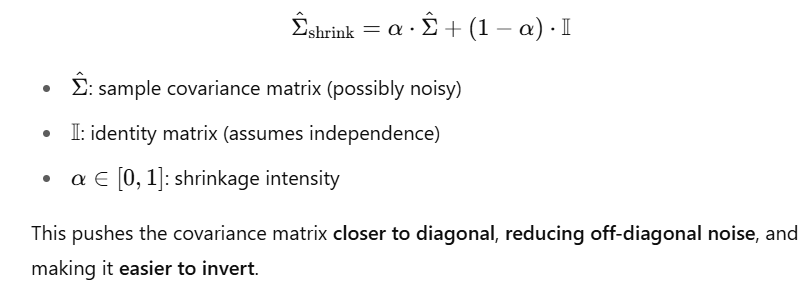

But we need to discriminate btween shrinking noise and signal... if not we can further eliminate the little signal we had at the begnining of the process :(

We can use the *Constant Residual Eigenvalue Method*

... How?

We assume that only the top few eigenvalues (and their associated eigenvectors) capture true signal (e.g., real structure in asset returns), while the rest are likely just noise. The idea is to:

Preserve the top
𝑖
i eigenvalues
𝜆1
,
…
,
𝜆
𝑖



Replace the remaining eigenvalues (associated with random eigenvectors) with a constant value

Ensure the trace is preserved (i.e., total variance remains unchanged)

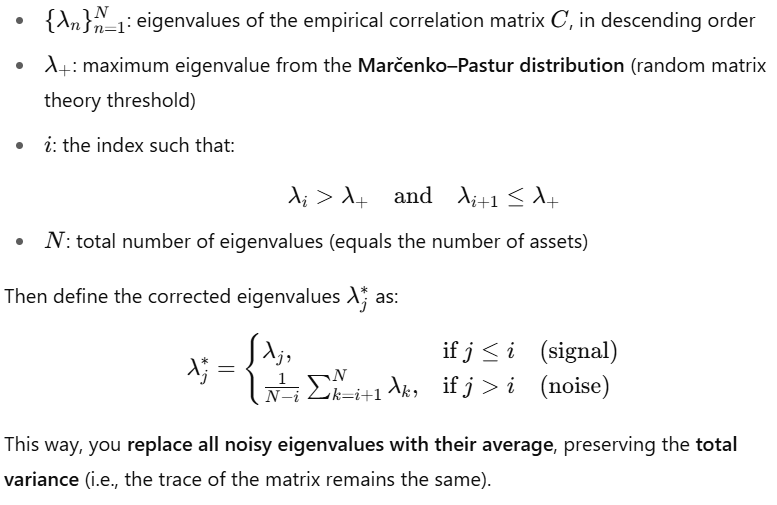

1. decompose C as C = WΛW' with W matrix of eigenvectors(cols) and Λ diag matrix of eigenvlaues
2. create a new diag matrix Λ* replacing the eigen val as explained before
3. get the denoised covar matrix Ce = WΛ*W' then normalize Ce to have diagonal 1
4. C* = diag(Ce)^-0.5 Ce diag(Ce)^-0.5

In [8]:
# DENOISING BY CONSTANT RESIDUAL EIGENVALUE

def denoisedCorr(eVal,eVec,nFacts):
#Remove noise from corr by ﬁxing random eigenvalues
  eVal_=np.diag(eVal).copy()
  eVal_[nFacts:]=eVal_[nFacts:].sum()/ﬂoat(eVal_.shape[0]-nFacts)
  eVal_=np.diag(eVal_)
  corr1=np.dot(eVec,eVal_).dot(eVec.T)
  corr1=cov2corr(corr1)
  return corr1
#---------------------------------------------------
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [9]:
eval0_plot = np.diag(eVal0)
eval1_plot = np.diag(eVal1)

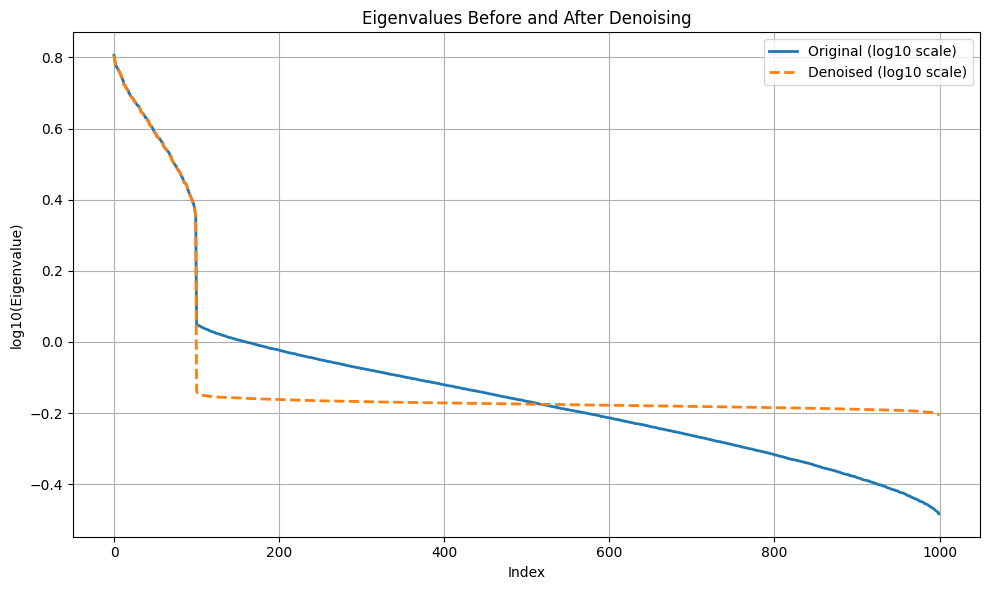

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(eval0_plot), label='Original (log10 scale)', linewidth=2,)
plt.plot(np.log10(eval1_plot), label='Denoised (log10 scale)', linewidth=2,linestyle='--')

plt.title('Eigenvalues Before and After Denoising')
plt.xlabel('Index')
plt.ylabel('log10(Eigenvalue)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Detoning

In financial data, especially in asset returns, a dominant "market mode" often appears in the first principal component (PC).

Wait... first PC?

The first PC coresponds to the highest eigenvalus of the matrix:
- The associated eigenvector captures the direction of maximum variance
- The eigenvalue itself tells how much of the total variance this direction explains

This component reflects broad, systemic co-movement across assets — e.g., everything falls during a market crash.

However, if you’re interested in clustering, relative performance, or idiosyncratic structure, this overwhelming market mode can obscure the relationships you're trying to discover.

So, detoning is a way to remove that market mode (and possibly more) from the correlation matrix.

How do we do it?

Take a denoised matrix C1 and separate it into:
- Wm and Λm be the market components (usually just the first eigenvector)
- Wd and Λd be the non market components

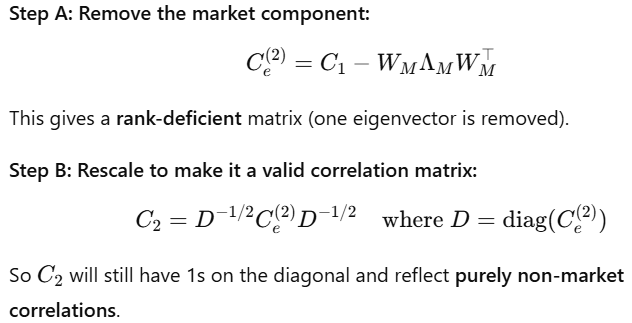

Is there any issue?

1. Yes... C2 is singular which means it cant be inverted and used for optimization problems (tho can be used for visualization or clustering)

2. No... we can make some modifs to perform optimizations:

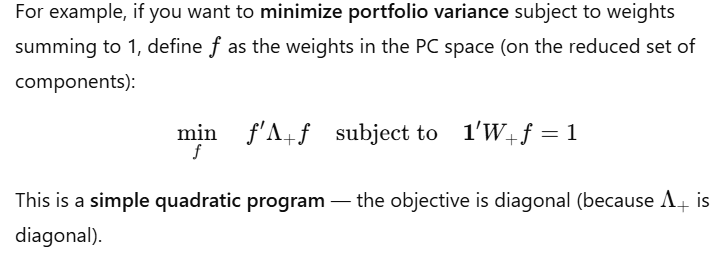


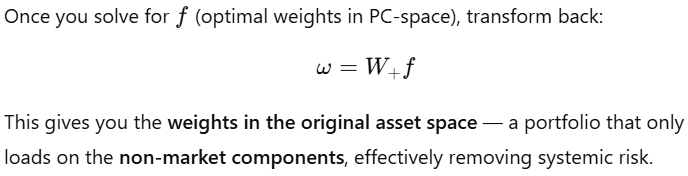

### Example 1 - Minimum Variance Portfolio

Compute the errors asociate with estimating a minimum variance portfolio (MVP) with and without denoising.

1. formBlockMatrix(nBlocks, bSize, bCorr)
Builds a block-diagonal correlation matrix:

Each block simulates an economic sector.

Assets within each block are correlated (bCorr, e.g., 0.5).

Assets between blocks are uncorrelated.

Result: a correlation matrix with clear clustered structure. This cov matrix a stylized representation of a true (nonempirical) detoned correlation
matrix of the S&P 500, where each block is associated with an economic sector.

and....
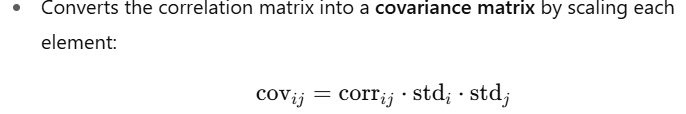

In [11]:
def formBlockMatrix(nBlocks,bSize,bCorr):
  block=np.ones((bSize,bSize))*bCorr
  block[range(bSize),range(bSize)]=1
  corr=block_diag(*([block]*nBlocks))
  return corr

def corr2cov(corr, std):
  """Convert correlation matrix and std vector to covariance matrix."""
  std = np.array(std)
  cov = corr * np.outer(std, std)
  return cov

formTrueMatrix(nBlocks, bSize, bCorr)
Shuffles the rows/columns of the correlation matrix to remove any obvious block structure (so you can test whether your algorithm can recover it).

Generates random volatilities (standard deviations) between 5% and 20% for each asset.

Uses corr2cov to build the true covariance matrix.

Generates random expected returns, consistent with the assumption that in an efficient market, returns are scaled with volatility:

𝜇
𝑖
∼
𝑁
(
𝜎
𝑖
,
𝜎
𝑖
)

In [12]:
def formTrueMatrix(nBlocks,bSize,bCorr):
  corr0=formBlockMatrix(nBlocks,bSize,bCorr)
  corr0=pd.DataFrame(corr0)
  cols=corr0.columns.tolist()
  np.random.shufﬂe(cols)
  corr0=corr0[cols].loc[cols].copy(deep=True)
  std0=np.random.uniform(.05,.2,corr0.shape[0])
  cov0=corr2cov(corr0,std0)
  mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
  return mu0,cov0
#---------------------------------------------------
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [13]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    """
    Simulates a random sample X from N(mu0, cov0) with nObs observations.
    Then estimates the sample mean and (optionally) a shrunk covariance matrix.

    Parameters:
    - mu0: true mean vector (N x 1)
    - cov0: true covariance matrix (N x N)
    - nObs: number of observations (T)
    - shrink: if True, use Ledoit-Wolf shrinkage; else use sample covariance

    Returns:
    - mu1: estimated mean vector (N x 1)
    - cov1: estimated covariance matrix (N x N)
    """
    # Draw T samples of N-dimensional observations
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size=nObs)

    # Estimate the mean vector
    mu1 = x.mean(axis=0).reshape(-1, 1)

    # Estimate the covariance matrix
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1 = np.cov(x, rowvar=False)

    return mu1, cov1


Then we denoise using the constant residual eigenvalue method!

In [14]:
def corr2cov(corr, std):
    """
    Convert a correlation matrix to a covariance matrix using asset standard deviations.

    Parameters:
    - corr: Correlation matrix (NxN)
    - std: 1D array of standard deviations (length N)

    Returns:
    - Covariance matrix (NxN)
    """
    cov = corr * np.outer(std, std)
    return cov

# -------------------------------------------------------

def deNoiseCov(cov0, q, bWidth):
    """
    Denoise a sample covariance matrix using Random Matrix Theory.

    Parameters:
    - cov0: Empirical covariance matrix (NxN)
    - q: T/N ratio, where T is the number of observations and N is the number of assets
    - bWidth: Bandwidth parameter for smoothing (used in eigenvalue filtering)

    Returns:
    - Denoised covariance matrix (NxN)
    """
    # Step 1: Convert covariance to correlation matrix
    corr0 = cov2corr(cov0)
    # Step 2: Get eigenvalues and eigenvectors (PCA)
    eVal0, eVec0 = getPCA(corr0)
    # Step 3: Estimate the maximum eigenvalue associated with noise
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    # Step 4: Estimate the number of significant factors (non-noise)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    # Step 5: Reconstruct the denoised correlation matrix
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    # Step 6: Convert denoised correlation matrix back to covariance using original std devs
    std = np.sqrt(np.diag(cov0))
    cov1 = corr2cov(corr1, std)

    return cov1


runs the following Monte Carlo experiment with 1,000
iterations: (1) draw a random empirical covariance matrix (shrinkage optional)
with T ¼ 1; 000; (2) denoise the empirical covariance matrix (optional); (3) derive the minimum variance portfolio, using the function optPort.

In [15]:
def optPort(cov, mu=None):
    """
    Compute optimal portfolio weights given a covariance matrix and optional mean vector.

    If mu is None, compute the minimum variance portfolio.
    Otherwise, compute the maximum Sharpe ratio portfolio (no risk-free rate).

    Parameters:
    - cov: Covariance matrix (NxN)
    - mu: Mean return vector (Nx1), or None for min variance

    Returns:
    - Portfolio weights (Nx1)
    """
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))

    if mu is None:
        mu = ones  # Treat as min variance portfolio (weights will sum to 1)

    w = np.dot(inv, mu)             # Inverse covariance * expected return
    w /= np.dot(ones.T, w)          # Normalize weights to sum to 1
    return w

# -------------------------------------------------------

# Simulation parameters
nObs = 1000             # Number of observations per trial
nTrials = 1000          # Number of Monte Carlo simulations
bWidth = 0.01           # Bandwidth for denoising
shrink = False          # Whether to use Ledoit-Wolf shrinkage
minVarPortf = True      # True = Minimum variance, False = Max Sharpe ratio

# Initialize dataframes to store weights for each trial
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)  # For denoised case

np.random.seed(0)

for i in range(nTrials):
    # Step 1: Simulate empirical mu and cov from true mu0 and cov0
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)

    # Step 2: Set mu1 to None if using min variance portfolio
    if minVarPortf:
        mu1 = None

    # Step 3: Denoise empirical covariance matrix
    q = nObs * 1.0 / cov1.shape[1]  # T/N
    cov1_d = deNoiseCov(cov1, q, bWidth)

    # Step 4: Compute optimal weights (original and denoised)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()


KeyboardInterrupt: 

In [16]:
# Compute true weights based on whether minVarPortf is True
w0 = optPort(cov0, None if minVarPortf else mu0)  # shape (N,1)

# Repeat w0 to match number of trials (rows)
w0_rep = np.repeat(w0.T, w1.shape[0], axis=0)  # shape (nTrials, N)

# Compute RMSE for each trial (row-wise)
rmse_empirical = np.sqrt(np.mean((w1.values - w0_rep)**2, axis=1))
rmse_denoised = np.sqrt(np.mean((w1_d.values - w0_rep)**2, axis=1))

# Average RMSE over all trials
print("Average RMSE (empirical):", rmse_empirical.mean())
print("Average RMSE (denoised):", rmse_denoised.mean())


Average RMSE (empirical): nan
Average RMSE (denoised): nan


What does this RMSE measure?

Average deviation of the estimated portfolio weights from the true portfolio weights.

Specifically, for each trial, it computes how far the weights
𝑤
w you get by optimizing on simulated covariance matrices are from the true optimal weights
𝑤
0
w
0
​
  computed on the true covariance matrix.

Lower RMSE means the estimated weights are closer to the true weights — which means better estimation.

Why do we compare weights this way?

Portfolio optimization depends heavily on the covariance matrix input. If your covariance estimates are noisy, the optimized weights can be far off from the “true” optimal weights.

Denoising (or detoning) the covariance matrix is supposed to reduce noise, yielding weights closer to the true optimal.

So, RMSE lets you quantify the improvement you get from denoising

### Exercises

#### 1. Implementing a detoning method

First we need ti understand that the true cov matrix is the one telling us how return move together if we had inifinite data points

While the empirical cov matrix is llimited as the data points are finite

Suppose a we have two stocks, the first has a 10% volatility and 0.8 coorelation with the second one.

We dont nknow it for sure, we can take the returns and calculate a cov matrix whihc might show some differences (say volatility of 10.3% and cov of 0.77) -> noiy estimate of the true relationshiè

We need to denoise and detone making the estimation closer to the true matrix!!

In [18]:
#create syinthetic data
np.random.seed(42)
N = 50
T = 500
#true covariance matrix randomly generated
A = np.random.randn(N, N)
true_cov = np.dot(A,A.T) #positive definite by construction
#generate returns
X = np.random.multivariate_normal(np.zeros(N), true_cov, T)
#rows are return vector at a given time
#cols are time series of retunrs for one asset

In [19]:
first_row = X[0]
first_col = X[:,0]

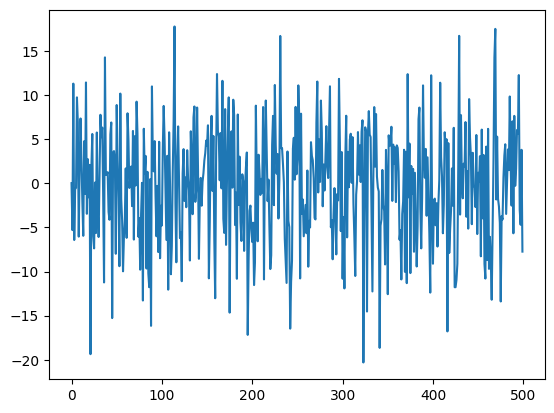

In [20]:
plt.plot(first_col)

Now we have the returns and we can compute the "empirical" correlation matrix

In [21]:
cov_emp = np.cov(X, rowvar=False)
std = np.sqrt(np.diag(cov_emp))
corr_emp = cov_emp/np.outer(std,std)

Then we denoise...

In [22]:
from scipy.linalg import eigh
def denoise_corr(corr, n_facts=5):
    eVals, eVecs = eigh(corr) #calcualte eigenval and eigenvec
    #order them from the biggest to the smallest
    eVals = eVals[::-1]
    eVecs = eVecs[:, ::-1]

    #keep the top n_facts eigval (signal) and replace the rest with tehir avg
    avg_noise = eVals[n_facts:].mean()
    eVals_denoised = np.copy(eVals)
    eVals_denoised[n_facts:] = avg_noise

    #rebuild denoised correlation matrix
    diag_e = np.diag(eVals_denoised)
    corr_denoised = eVecs @ diag_e @ eVecs.T

    #normalize to have ones on diagonal
    diag_sqrt = np.sqrt(np.diag(corr_denoised))
    corr_denoised /= diag_sqrt[:, None]
    corr_denoised /= diag_sqrt[None, :]

    return corr_denoised

C1 = denoise_corr(corr_emp, n_facts=5)

Finally detoning!

In [23]:
def detone_corr(corr, n_market=1):
    #same as before...
    eVals, eVecs = eigh(corr)
    eVals = eVals[::-1]
    eVecs = eVecs[:, ::-1]

    #separate market and detoned parts
    eVals_market = eVals[:n_market]
    eVecs_market = eVecs[:, :n_market]
    eVals_detoned = eVals[n_market:]
    eVecs_detoned = eVecs[:, n_market:]

    #build market component matrix
    market_component = eVecs_market @ np.diag(eVals_market) @ eVecs_market.T

    #remove market component
    corr_detoned = corr - market_component

    #normalize diagonal to 1 again
    diag_sqrt = np.sqrt(np.diag(corr_detoned))
    corr_detoned /= diag_sqrt[:, None]
    corr_detoned /= diag_sqrt[None, :]

    return corr_detoned, eVecs_detoned, eVals_detoned


#### Efficient market frontiers

In [24]:
#--- get data and continion number ---#

#create sysnthetic data
np.random.seed(42)
T,N = 1000,50 #1000 days & 50 stocks
X = np.random.normal(0.1,0.1,size=(T,N))
#corr matrix
cov = np.cov(X,rowvar=False)
stds = np.sqrt(np.diag(cov))
corr = cov/np.outer(stds,stds)
#condition number
cond_num = np.linalg.cond(corr)
print(f"Condition number of correlation matrix: {cond_num:.2f}")

Condition number of correlation matrix: 2.30


We need to find the weights w minimizing the risk (variance)


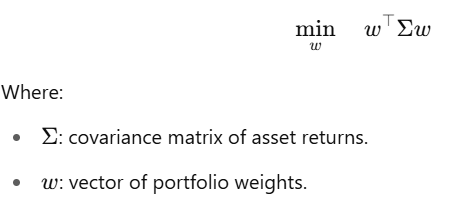

with constraints:
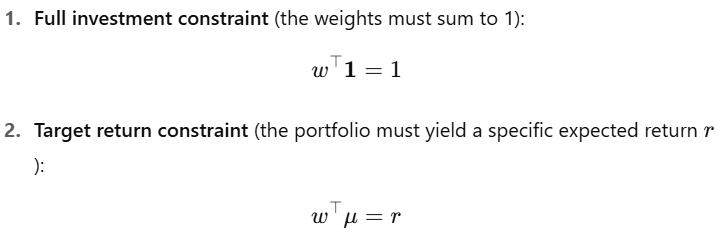

- N assets -> portfolio return R = sum(wi*ri) for i =1,....,N
- Now Var(R) = Var(w'r) = Var(sum(wi*ri)) = sumi(sumj(wi*wj*Cov(ri,rj))) = w'Σw -> obj function!!!

In [25]:
#--- compute 100 efficient frontiers ---#
def optMVP(cov):
  inv_cov = np.linalg.inv(cov) #calcualte Sigma^-1
  ones = np.ones((cov.shape[0],1)) #create identity matrix
  w = inv_cov @ ones #compute unclased wiights
  w = w/(ones.T @ inv_cov @ ones) #normalize the weights
  return w.flatten() #return the weights as 1D array

#number of trials
n_trials = 100
np.random.seed(42)
#generate n_trials vecotrs of returns with meand and std 10%
mu_trials = np.random.normal(0.1,0.1,size =(n_trials,N))

#create an empty matrix to store weights
weights_trials = np.zeros((n_trials,N))

for i in range(n_trials):
  mu = mu_trials[i]
  weights_trials[i] = optMVP(cov)


Ok but here we calcualte the weights by minimizing risk not taking care about returns... we instead need a mean-var optimization... that is max th ereturn for a given risk or eequivalently...

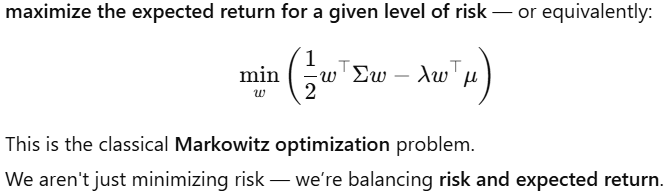

In [26]:
#the code changes in this way...
def opt_mean_variance_portfolio(cov, mu):
    """Compute the mean-variance optimal portfolio weights (sum to 1)."""
    inv_cov = np.linalg.inv(cov)
    ones = np.ones((cov.shape[0], 1))
    mu = mu.reshape(-1, 1)
    w = inv_cov @ mu
    w /= ones.T @ w  # Normalize to sum to 1
    return w.flatten()

N = cov_empirical.shape[0]
n_trials = 100
np.random.seed(42)
mu_trials = np.random.normal(0.10, 0.10, size=(n_trials, N))
weights_trials = np.zeros((n_trials, N))
for i in range(n_trials):
    mu = mu_trials[i]
    weights_trials[i] = opt_mean_variance_portfolio(cov_empirical, mu)

    #calcualte mean weights
w_mean = weights_trials.mean(axis=0)
#errors
errors = weights_trials - w_mean
var_error = np.mean(np.sum(errors**2,axis=1)) #MSD
print("Variance of errors across efficient portfolios:", var_error)


Variance of errors across efficient portfolios: 0.0010753579512321509


### Effect of denoising, shrinking an detoning

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.linalg import eigh
from numpy.linalg import inv

# Helper functions for covariance <-> correlation conversion
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    return corr

def corr2cov(corr, std):
    return corr * np.outer(std, std)

# Denoising function (simple example based on eigenvalues)
def deNoiseCov(cov, q, bWidth):
    corr = cov2corr(cov)
    eVals, eVecs = eigh(corr)
    eVals = eVals[::-1]
    eVecs = eVecs[:, ::-1]

    # Threshold from Marcenko-Pastur distribution or similar heuristic
    lambda_max = (1 + np.sqrt(q))**2 + bWidth

    # Keep eigenvalues above threshold (signal), set others to average noise
    n_facts = np.sum(eVals > lambda_max)
    eVals_denoised = np.copy(eVals)
    noise_mean = np.mean(eVals[n_facts:])
    eVals_denoised[n_facts:] = noise_mean

    # Reconstruct correlation matrix
    corr_denoised = (eVecs * eVals_denoised) @ eVecs.T

    # Fix numerical issues: make symmetric and set diag=1
    corr_denoised = (corr_denoised + corr_denoised.T) / 2
    np.fill_diagonal(corr_denoised, 1.0)

    std = np.sqrt(np.diag(cov))
    return corr2cov(corr_denoised, std)

# Detoning function to remove market component
def detone_cov(cov, n_market=1):
    corr = cov2corr(cov)
    eVals, eVecs = eigh(corr)
    eVals = eVals[::-1]
    eVecs = eVecs[:, ::-1]

    # Remove top n_market eigenvalues/components (market)
    eVals[n_market:] = eVals[n_market:]
    eVals[:n_market] = 0

    corr_detoned = (eVecs * eVals) @ eVecs.T
    corr_detoned = (corr_detoned + corr_detoned.T) / 2
    np.fill_diagonal(corr_detoned, 1.0)
    std = np.sqrt(np.diag(cov))
    return corr2cov(corr_detoned, std)

# Mean-variance optimization (weights sum to 1)
def optPort(cov, mu=None):
    inv_cov = inv(cov)
    ones = np.ones((cov.shape[0], 1))
    if mu is None:
        mu = ones
    w = inv_cov @ mu.reshape(-1,1)
    w /= (ones.T @ w)
    return w.flatten()

# -- Synthetic data generation (true covariance and returns) --

#create sysnthetic data
np.random.seed(42)
T,N = 1000,50 #1000 days & 50 stocks
X = np.random.normal(0.1,0.1,size=(T,N))
#corr matrix
cov = np.cov(X,rowvar=False)
stds = np.sqrt(np.diag(cov))
corr = cov/np.outer(stds,stds)

# Empirical covariance from X
cov_empirical = np.cov(X, rowvar=False)

# Ledoit-Wolf shrinkage covariance
cov_shrunk = LedoitWolf().fit(X).covariance_

# Denoised covariance
q = T / N
bWidth = 0.01
cov_denoised = deNoiseCov(cov_empirical, q, bWidth)

# Detoned covariance (remove market component)
cov_detoned = detone_cov(cov_denoised, n_market=1)


# Generate 100 alternative expected returns (mean=10%, std=10%)


#ààààààààààà
n_trials = 100
mu_trials = np.random.normal(0.10, 0.10, size=(n_trials, N))
weights_trials = np.zeros((n_trials, N))

# Storage for weights and RMSE errors
weights_emp = np.zeros((n_trials, N))
weights_denoised = np.zeros((n_trials, N))
weights_shrunk = np.zeros((n_trials, N))
weights_detoned = np.zeros((n_trials, N))

rmse_emp = []
rmse_denoised = []
rmse_shrunk = []
rmse_detoned = []

# Optimize portfolios for each covariance and each mu_trial
for i in range(n_trials):
    mu_i = mu_trials[i]

    w_emp = optPort(cov_empirical, mu_i)
    w_denoised = optPort(cov_denoised, mu_i)
    w_shrunk = optPort(cov_shrunk, mu_i)
    w_detoned = optPort(cov_detoned, mu_i)

    weights_emp[i] = w_emp
    weights_denoised[i] = w_denoised
    weights_shrunk[i] = w_shrunk
    weights_detoned[i] = w_detoned

w_mean_emp = weights_emp.mean(axis=0)
w_mean_denoised = weights_denoised.mean(axis=0)
w_mean_shrunk = weights_shrunk.mean(axis=0)
w_mean_detoned = weights_detoned.mean(axis=0)

errors_emp = weights_emp - w_mean_emp
errors_denoised = weights_denoised - w_mean_denoised
errors_shrunk = weights_shrunk - w_mean_shrunk
errors_detoned = weights_detoned - w_mean_detoned

errors_var_emp = np.mean(np.sum(errors_emp**2, axis=1))
errors_var_denoised = np.mean(np.sum(errors_denoised**2, axis=1))
errors_var_shrunk = np.mean(np.sum(errors_shrunk**2, axis=1))
errors_var_detoned = np.mean(np.sum(errors_detoned**2, axis=1))

print("Variance of errors across efficient portfolios (Empirical):", errors_var_emp)
print("Variance of errors across efficient portfolios (Denoised):", errors_var_denoised)
print("Variance of errors across efficient portfolios (Ledoit-Wolf Shrinkage):", errors_var_shrunk)
print("Variance of errors across efficient portfolios (Detoned):", errors_var_detoned)


Variance of errors across efficient portfolios (Empirical): 0.023211535729748312
Variance of errors across efficient portfolios (Denoised): 0.020210411669865834
Variance of errors across efficient portfolios (Ledoit-Wolf Shrinkage): 0.02009645967439826
Variance of errors across efficient portfolios (Detoned): 0.1677576494978515


## Ch3 - Distance Metrics

### Introduction

Correlation suffers from some critical limitations as a measure of codepen-
dence. In this section, we overcome those limitations by reviewing informa-
tion theory concepts that underlie many modern marvels.
As it turns out, information theory in general, and the concept of Shannon’s
entropy in particular, also have useful applications in ﬁnance. The key idea
behind entropy is to quantify the amount of uncertainty associated with a
random variable. Information theory is also essential to ML, because the
primary goal of many ML algorithms is to reduce the amount of uncertainty
involved in the solution to a problem.

### Correlation-Based Metrics

Correlation is a useful measure of linear codependence. For example, we could use correlations to identify
clusters of highly interrelated securities.

But correlation is not a metric, because it does not satisfy nonnegativity and triangle inequality conditions.

Metrics are important
because they induce an intuitive topology on a set. Without that intuitive
topology, comparing non-metric measurements of codependence can lead to
rather incoherent outcomes.

X, Y random vectors of size T with correlation ρ[X,Y] and σ[X,Y] = ρ[X,Y]σ[X]σ[Y] then we have teh *Pearson's Correlation* which is a metric:

d[X,Y] = sqrt(0.5*(1-ρ[X,Y]))

Note:
- d is normalized between 0 and 1
- treats variables with negative corr as more distant even if the abs value is the same
- aligns with a long-only portfolio where negative correlatin implies diversification


For long-short portfolio we use instead
d[X,Y] = sqrt(1-abs(ρ[X,Y])) since the sign og ρ matters less as sort position can flip the sign


### Marginal and Joint Entropy

Correlation rpesents 3 issues:
- Measures linear codependency only
- Is highly influenced by outliers
- Its application out of multivariate normal case is questionable

Take a discrete rv X that takes a value x from the set Sx with prob p(x). The **entropy** of x is:

H[X] = - Σ p(x)log(p(x)) (summation over x in Sx)

It measures the amount of uncertainty associated with X. It is 0 if all prb is concentrated in one element of Sx and reaches its max value when all the elemtnbs are uniformely distributed:

p(x) = 1/len(Sx)

Taken X and Y the joint entropy H[X,Y]:
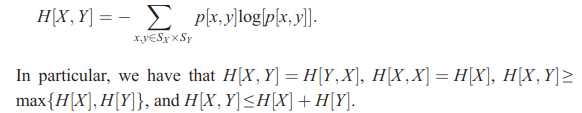

### Conditional Entropy

The conditional entropy of X given Y:
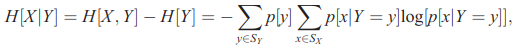

with H[X|X] = 0 and H[X]>H[X|Y]

### KL Divergence and Cross Entropy

p, q two discrete prob distributions, then the KL divergence between p and q is:
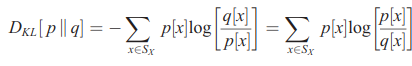


And the cross entropy Hc

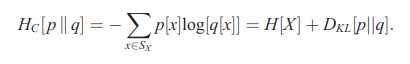

represents the uncertainty associated with X when evaluatiing its information using a wrong distribution q rather than the true one p -- very important in *classification*

### Mutual Information

is the decras in uncertainty (or informaionl gain) in X that results from knowing the value of Y:

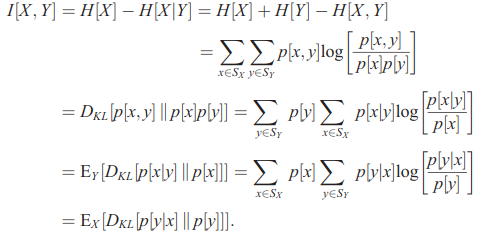

Note:
- I[X,Y]>0, I[X,Y] = I[Y,X], I[X,X] = H[X] and that when X,Y are independent p(x,y)=p(x)p(y) hence I[X,Y]=0
- It is not a  metric (triang ineq not satisfied)

An important property is teh grouping one:
image.png

Useful to decompose mutal information into simpler constituents --> aggomerative clustering and forward feature selection


In [30]:
# --- How to compute the metrics we defined? ---#

import numpy as np, scipy.stats as ss
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

# Define sample data for x and y, and define bins
np.random.seed(0) # for reproducibility
x = np.random.rand(100)
y = np.random.rand(100)
bins = 10 # You can adjust the number of bins as needed

cXY = np.histogram2d(x,y,bins) [0]
hX=ss.entropy(np.histogram(x,bins)[0])#marginal
hY=ss.entropy(np.histogram(y,bins)[0])#marginal
iXY=mutual_info_score(None,None,contingency=cXY)
iXYn=iXY/min(hX,hY)#normalizedmutualinformation
hXY=hX+hY-iXY#joint
hX_Y=hXY-hY#conditional
hY_X=hXY-hX#conditional

###  Variation of Information

Lower bound VI[X,Y] = 0 <-> X = Y adn uppr biund VI[X,Y] <= H[X,Y].

To have VI bounded betweeen 0 and 1 we need to normalize by H[X,Y].

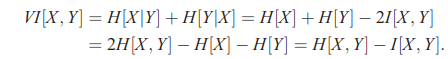

### Discretization

What happens if we have continous (non-discrete) variables?

Take a continous rv X woth pdf f(x), thne its differential entropy is:

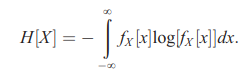


For a gaussian rv is 1/2log(2πeσ^2) ~ 1.42. Now, if we have a finite sample of rv we do the following:
 - divide the range in Bx bins of equal size Δx
 - Δx = (max(x)-min(x))/Bx

So we get:
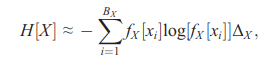

Where f(x9) is the frequency of observations falling in the ith bin. Then f(xi)ΔXi = p(xi), the chance of picking an observation in Δxi. This can be estiated bi Ni/N where Ni is the number of obs in Δxi... this leads to:

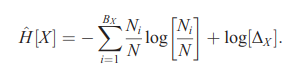

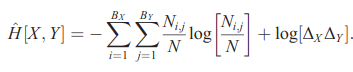

From these estimators we can derive:
- Conditional entropy
- Mutual information
- Variation of information

But results might be biased by the choice of the bins Bx and By -> optimal choice?

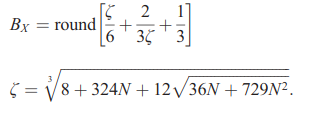

### Distance between Partitions

We have seen distanc metrics between two rvs, what about comparing two partitions of datasets?

A partiton P of a dataset D is an unordered set of mutually dsijoint nonempty subsets.

Now, if the prob of picking d in D is p(d) = 1/||D|| and to pick in Dk is p(k) = 1/||Dk|| then this p(k) is associated with a discrete rv taking value k from S = {1,...,K}. The uncertainty associated with picking this discrete rv is:

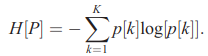

Which only depends on the size of Dk and not of D.

Now if we repeat this with another subset, the joint probability that d is in D and belongs to Dk in P and also belongs to Dk' in P' is:

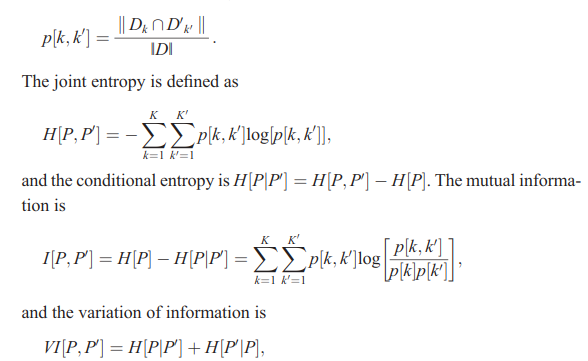

Now, H[P|P'] is the amount of info about P we lose wile H[P'|P] measures the amount of info about P' gained when goign from partions P to P'.

We ahve three properties:
- It is a metric
- has an upper bound VI[P,P']<=log(||D||)
- If the number of subsets is bounded to be K<=sqrt(||D||) then VI[P,P']<=log(K)

These are useful as we can normalize distances between partitions and compare partitioning algorithms between datasets (useful in unsupervised learning).

### Experimental Results

The mutual info qunatifies the amount of info shared by two rvs. Like the corr coeff, when normalized it ranges between 0 and 1 and is not a metric. Given two gaussian rvs X, Y with correlation ρ the mutual info I[X,Y] = 1/2log(1-ρ^2).

We can use the normalized mutual information as the analogue of the correlation coefficient for lienar algebra.

In [41]:
import numpy as np
import scipy.stats as ss
from sklearn.metrics import mutual_info_score

# Placeholder function for numBins
# You may need to replace this with your actual numBins logic
def numBins(n, corr=None):
    # Simple example: return a fixed number of bins or based on data size
    return int(np.sqrt(n)) if n > 0 else 1

def mutualInfo(x,y,norm=False):
  #mutual information
  bXY=numBins(x.shape[0],corr=np.corrcoef(x,y)[0,1])
  cXY=np.histogram2d(x,y,bXY)[0]
  iXY=mutual_info_score(None,None,contingency=cXY)
  if norm:
    hX=ss.entropy(np.histogram(x,bXY)[0])#marginal
    hY=ss.entropy(np.histogram(y,bXY)[0])#marginal
    iXY/=min(hX,hY)#normalizedmutualinformation
  return iXY

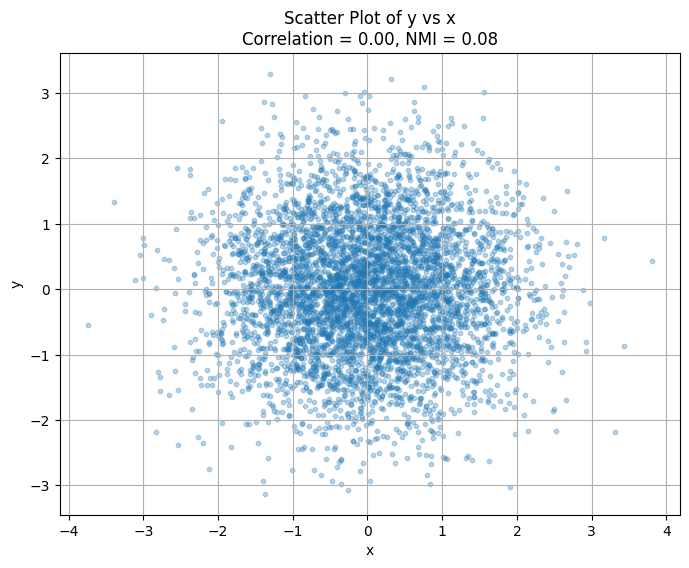

In [43]:
#---------------------------------------------------
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
alpha = 0 #change this to see how nmi and corr evolve!
y=alpha*x+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, s=10)
plt.title(f'Scatter Plot of y vs x\nCorrelation = {corr:.2f}, NMI = {nmi:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

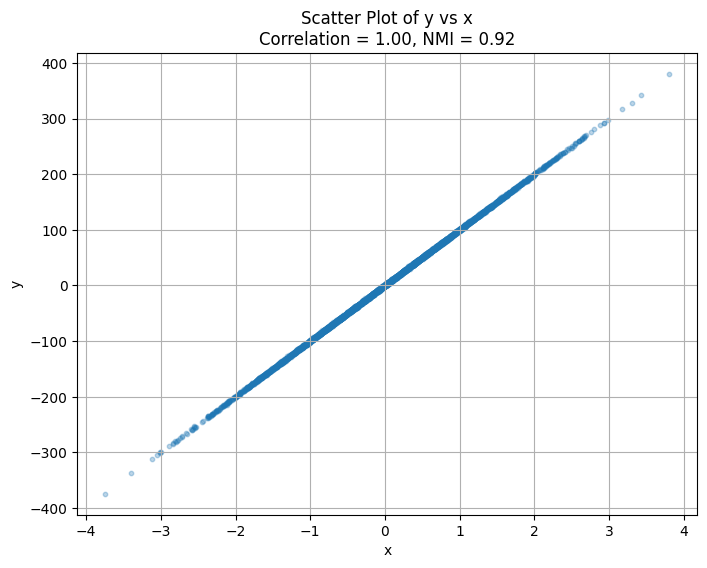

In [44]:
#---------------------------------------------------
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
alpha = 100 #change this to see how nmi and corr evolve!
y=alpha*x+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, s=10)
plt.title(f'Scatter Plot of y vs x\nCorrelation = {corr:.2f}, NMI = {nmi:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

With alpha = 100
- corr ~ 1
- nmi ~ 0.9

With alpha = 10000
- corr ~ 1
- nmi ~ 0.995


Now what happens if y = α*abs(x)+e?
No correlation as the relationship is completely non-linear!

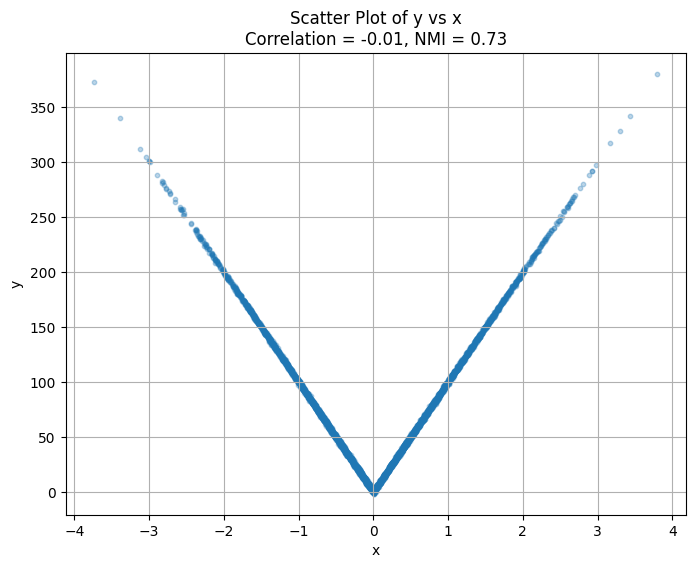

In [46]:
#---------------------------------------------------
size,seed=5000,0
np.random.seed(seed)
x=np.random.normal(size=size)
e=np.random.normal(size=size)
alpha = 100 #change this to see how nmi and corr evolve!
y=alpha*abs(x)+e
nmi=mutualInfo(x,y,True)
corr=np.corrcoef(x,y)[0,1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, s=10)
plt.title(f'Scatter Plot of y vs x\nCorrelation = {corr:.2f}, NMI = {nmi:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()